First add the data functions to the path

In [6]:
import sys
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from pathlib import Path
notebook_dir = !pwd # Replace with !echo %cd% if using windows
library_dir = Path(notebook_dir[0]).parent.absolute()
sys.path.append(str(library_dir))
data_raw_path = library_dir / 'data' / 'raw'

from src.data.adcp_mission_analysis import adcp_import_data, add_dive_averages
from src.data.beam_mapping import beam2enu, beam_from_center


Use better plotting defaults

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style_path = library_dir / 'src' / 'visualization' / 'presentation.mplstyle'
style.use(str(style_path))

Get an overview of the dataset

In [3]:
overview, mission_dict = adcp_import_data(data_raw_path)

In [85]:
def add_dive_averages(mission_summary, profiles_dict):
    """

    :param mission_summary: DataFrame of info for each dive cycle
    :param profiles_dict: dictionary of extra data on each dive
    :return: Augmented data frame with information averaged over cell 5, 11 m from the glider
    """
    beam_attrs = pd.DataFrame(index=mission_summary.index, columns=['cor_beam_1', 'cor_beam_2', 'cor_beam_3',
                                                             'cor_beam_4', 'amp_beam_1', 'amp_beam_2',
                                                             'amp_beam_3', 'amp_beam_4', 'beam_miss',
                                                            'pitch', 'roll', 'heading',
                                                                   'good_angle'])
    for cycle in mission_summary.index:
        cycle_dict = profiles_dict[cycle].ad2cp_dict
        physical_beam = cycle_dict['Physicalbeam'][0, :]
        cors = profiles_dict[cycle].cor_beam
        amps = profiles_dict[cycle].amp_beam
        if 3.0 in physical_beam:
            beam_attrs.cor_beam_2[cycle] = np.nanmean(cors[:, 5, 0])
            beam_attrs.cor_beam_3[cycle] = np.nanmean(cors[:, 5, 1])
            beam_attrs.cor_beam_4[cycle] = np.nanmean(cors[:, 5, 2])
            beam_attrs.amp_beam_2[cycle] = np.nanmean(amps[:, 5, 0])
            beam_attrs.amp_beam_3[cycle] = np.nanmean(amps[:, 5, 1])
            beam_attrs.amp_beam_4[cycle] = np.nanmean(amps[:, 5, 2])
        else:
            beam_attrs.cor_beam_1[cycle] = np.nanmean(cors[:, 5, 0])
            beam_attrs.cor_beam_2[cycle] = np.nanmean(cors[:, 5, 1])
            beam_attrs.cor_beam_4[cycle] = np.nanmean(cors[:, 5, 2])
            beam_attrs.amp_beam_1[cycle] = np.nanmean(amps[:, 5, 0])
            beam_attrs.amp_beam_2[cycle] = np.nanmean(amps[:, 5, 1])
            beam_attrs.amp_beam_4[cycle] = np.nanmean(amps[:, 5, 2])
        beam_attrs.beam_miss[cycle] = np.nanmean(profiles_dict[cycle].beam_miss[:,5])
        beam_attrs.pitch[cycle] = np.nanmean(np.abs(profiles_dict[cycle].pitch))
        beam_attrs.roll[cycle] = np.nanmean(np.abs(profiles_dict[cycle].roll))
        beam_attrs.heading[cycle] = np.nanmean(profiles_dict[cycle].heading)
        beam_attrs.good_angle[cycle] = 100*sum(profiles_dict[cycle].beam_miss[:,5]<1.0)/len(profiles_dict[cycle].beam_miss)
    #mission_summary = mission_summary.join(beam_attrs)
    return mission_summary, beam_attrs

In [86]:
overview, beam_attrs = add_dive_averages(overview, mission_dict)


In [87]:
beam_attrs

,cor_beam_1,cor_beam_2,cor_beam_3,cor_beam_4,amp_beam_1,amp_beam_2,amp_beam_3,amp_beam_4,beam_miss,pitch,roll,heading,good_angle
0001a,NaN,20.1064,16.4255,17.2128,NaN,29.6702,29.0426,29.3511,2.6974,42.6309,4.44085,235.983,6.38298
0001b,46.8214,48.8571,NaN,46.3214,33.6964,33.2946,NaN,32.8571,1.87585,34.3086,4.59,184.709,32.1429
0002a,NaN,63.5455,62.8,62.7091,NaN,34.8818,34.5636,34.3455,1.60773,29.5591,5.61491,115.971,40
0002b,88.1833,87.6667,NaN,86.35,37.8167,37.2583,NaN,36.7417,0.898507,22.2342,5.542,134.029,60
0003a,NaN,73.8457,75.9074,73.6296,NaN,33.2438,33.7346,33.0463,0.821654,16.9001,4.67148,115.131,54.9383
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0153b,96.5814,96.0698,NaN,95.6977,42.7674,42.1163,NaN,41.5233,0.77738,25.4237,2.5007,106.602,83.7209
0154a,NaN,92.7059,93.2353,94.7059,NaN,39.0294,40.4706,39.7059,1.54943,26.01,3.98588,35.48,47.0588
0154b,95.7857,95.1429,NaN,95.1429,41.7143,41,NaN,40.6429,0.983536,24.62,4.05286,97.7407,64.2857
0155a,NaN,93.8889,91.9259,93.5926,NaN,39.6481,40.0926,39,1.37718,26.317,4.59037,180.342,33.3333


In [84]:
np.percentile(beam_attrs.percent_1m_miss,20)

90.70567986230637

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f14d4865510>,
      dtype=object)

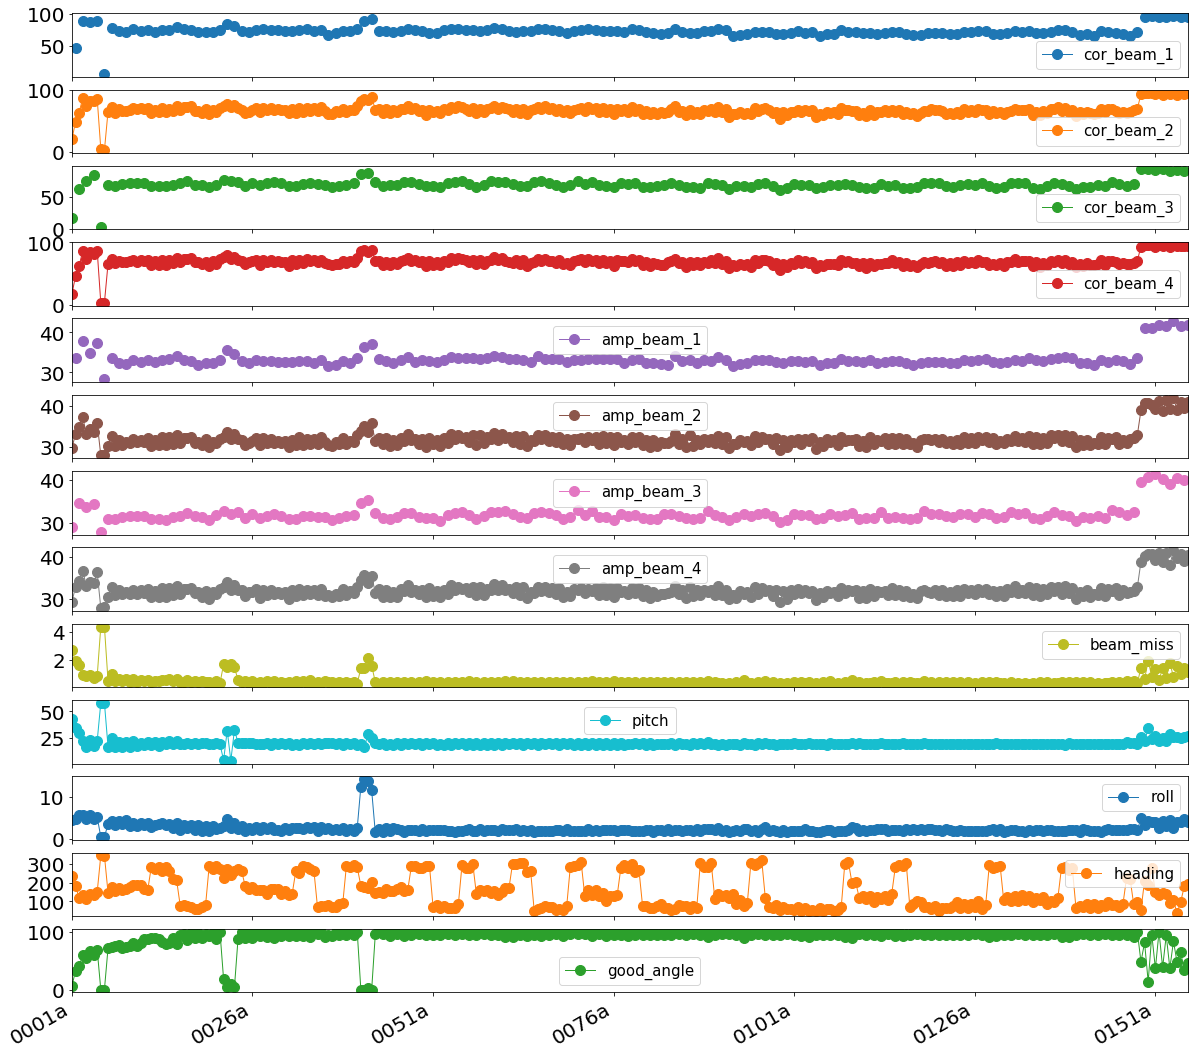

In [88]:
beam_attrs.plot(subplots=True,figsize=(20,20),marker='o')

In [58]:
b2 = beam_attrs.drop(['cor_beam_1', 'amp_beam_1','cor_beam_3', 'amp_beam_3'],axis=1)

In [60]:
b2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310 entries, 0001a to 0155b
Data columns (total 5 columns):
cor_beam_2    310 non-null object
cor_beam_4    310 non-null object
amp_beam_2    310 non-null object
amp_beam_4    310 non-null object
beam_miss     310 non-null object
dtypes: object(5)
memory usage: 24.5+ KB


In [61]:
foo = mission_dict['0041a']
bar = mission_dict['0041b']

In [62]:
foo.pitch

masked_array(data=[-66.85     , -64.29     , -25.42     , -22.029999 ,
                   -22.34     , -21.81     , -20.439999 , -21.15     ,
                   -21.76     , -21.66     , -21.85     , -22.519999 ,
                   -20.73     , -21.859999 , -20.869999 , -19.91     ,
                   -20.859999 , -20.24     , -20.119999 , -21.289999 ,
                   -21.07     , -21.65     , -22.4      , -21.84     ,
                   -21.27     , -19.71     , -19.74     , -20.14     ,
                   -21.14     , -20.539999 , -20.02     , -20.26     ,
                   -20.18     , -19.89     , -21.01     , -20.32     ,
                   -19.55     , -19.74     , -19.77     , -19.74     ,
                   -19.58     , -20.48     , -20.55     , -20.72     ,
                   -20.52     , -20.699999 , -20.38     , -18.88     ,
                   -18.8      , -19.84     , -19.8      , -20.13     ,
                   -20.289999 , -19.71     , -19.34     , -19.369999 ,
      

In [ ]:
np.shape(foo.beam_miss)

In [ ]:
foo.ad2cp_dict['Physicalbeam']

In [ ]:
a = foo.ad2cp_dict['Physicalbeam'][0,:]
np.shape(foo.cor_beam)

In [ ]:
#vel_enu = beam2enu(foo.vel_beam, np.transpose(np.tile(foo.pitch,(3,15,1))), np.transpose(np.tile(foo.roll,(3,15,1))), np.transpose(np.tile(foo.heading,(3,15,1))), dive_limb = 'Ascent')
beam_miss = beam_from_center(np.transpose(np.tile(foo.pitch,(len(foo.cell_center),1))),
                              np.transpose(np.tile(foo.roll,(len(foo.cell_center),1))),
                              np.tile(foo.cell_center, (len(foo.pitch),1)))

In [ ]:
beam_attrs = pd.DataFrame(index=overview.index, columns=['cor_beam_1', 'cor_beam_2', 'cor_beam_3',
                                                         'cor_beam_4', 'amp_beam_1','amp_beam_2',
                                                        'amp_beam_3','amp_beam_4'])


In [ ]:
beam_attrs


In [ ]:
for cycle in overview.index:
    cycle_dict = mission_dict[cycle].ad2cp_dict
    physical_beam = cycle_dict['Physicalbeam'][0,:]
    cors = mission_dict[cycle].cor_beam
    amps = mission_dict[cycle].amp_beam
    if 3.0 in physical_beam:
        beam_attrs.cor_beam_2[cycle] = np.nanmean(cors[:,4,0])
        beam_attrs.cor_beam_3[cycle] = np.nanmean(cors[:,4,1])
        beam_attrs.cor_beam_4[cycle] = np.nanmean(cors[:,4,2])
        beam_attrs.amp_beam_2[cycle] = np.nanmean(amps[:,4,0])
        beam_attrs.amp_beam_3[cycle] = np.nanmean(amps[:,4,1])
        beam_attrs.amp_beam_4[cycle] = np.nanmean(amps[:,4,2])
    else:
        beam_attrs.cor_beam_1[cycle] = np.nanmean(cors[:,4,0])
        beam_attrs.cor_beam_2[cycle] = np.nanmean(cors[:,4,1])
        beam_attrs.cor_beam_4[cycle] = np.nanmean(cors[:,4,2])
        beam_attrs.amp_beam_1[cycle] = np.nanmean(amps[:,4,0])
        beam_attrs.amp_beam_2[cycle] = np.nanmean(amps[:,4,1])
        beam_attrs.amp_beam_4[cycle] = np.nanmean(amps[:,4,2])
            
    

In [ ]:
overview.join(beam_attrs)

In [ ]:
pitches = np.transpose(np.tile(foo.pitch,(len(foo.cell_center),1)))
centers = np.tile(foo.cell_center, (len(foo.pitch),1))
np.shape(pitches)
np.shape(centers)

In [ ]:
foo.cell_center
foo.beam_miss

In [ ]:
cor_means = []
for key in list(mission_dict):
    profile=mission_dict[key]
    cor = profile.amp_beam
    cor_means.append(np.nanmean(cor[:6,:6,0]))

In [ ]:
cor_means

In [ ]:
np.shape(cor)

In [ ]:
cor = profile.cor_beam
plt.pcolor(cor[:,:,2])

In [ ]:
cor_beam amp_beam vel_beam